In [1]:
# Setup y compatibilidad con src/* (Windows, rutas, wrappers)
import sys, os, asyncio

# Evitar warning de ZMQ en Windows
if sys.platform.startswith("win"):
    try:
        asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())
    except Exception:
        pass

# Asegurar import de src/
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift, ifft2, ifftshift
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

# Cargar imagen de prueba (normalizada a [0,1])
from skimage import data
img = data.camera().astype(float)
img = (img - img.min()) / (img.max() - img.min() + 1e-12)
M, N = img.shape

# Espectro centrado
F = fftshift(fft2(img))

# Importar funciones del paquete src
from src.compression import adaptive_radial_prune as _adaptive_radial_prune_src, global_prune
from src.metrics import evaluate as _evaluate_dict
from src.fourier_tools import energy_from_spectrum

# Wrapper para mantener la firma evaluate -> (mse, psnr, ssim)
def evaluate(a, b, data_range=None):
    d = _evaluate_dict(a, b, data_range=data_range)
    return d["mse"], d["psnr"], d["ssim"]

# Wrapper de compatibilidad para adaptive_radial_prune (firma antigua devuelve 3 valores)
def adaptive_radial_prune(F_in, alpha, num_bins=64):
    mask, kept = _adaptive_radial_prune_src(F_in, alpha, num_rings=int(num_bins))
    alloc = {}
    return mask, kept, alloc



>>> Alpha = 0.3  (bins=12)
 Global: k_target=78643, k_selected=78643, E_frac=0.000004


 Adaptive: k_target=78643, k_selected=78643, E_frac=0.000004, alloc_sample={}

>>> Alpha = 0.5  (bins=12)


 Global: k_target=131072, k_selected=131072, E_frac=0.000004
 Adaptive: k_target=131072, k_selected=131072, E_frac=0.000004, alloc_sample={}



>>> Alpha = 0.7  (bins=12)
 Global: k_target=183501, k_selected=183500, E_frac=0.000004


 Adaptive: k_target=183501, k_selected=183500, E_frac=0.000004, alloc_sample={}

CSV guardado en ../reports/compression_alpha_results.csv
   alpha    method       k       mse       psnr      ssim   energy_kept  \
0    0.3    global   78643  0.000400  33.976393  0.876961  88909.728463   
1    0.3  adaptive   78643  0.000579  32.373178  0.816743  88862.309808   
2    0.5    global  131072  0.000161  37.919761  0.933256  88972.566035   
3    0.5  adaptive  131072  0.000228  36.416296  0.906749  88954.921836   
4    0.7    global  183500  0.000050  43.043138  0.974178  89001.981807   
5    0.7  adaptive  183500  0.000076  41.194166  0.962292  88995.053145   

   energy_frac  bytes_est  comp_ratio alloc  
0     0.000004    1887432    1.111114  None  
1     0.000004    1887432    1.111114    {}  
2     0.000004    3145728    0.666667  None  
3     0.000004    3145728    0.666667    {}  
4     0.000004    4404000    0.476193  None  
5     0.000004    4404000    0.476193    {}  


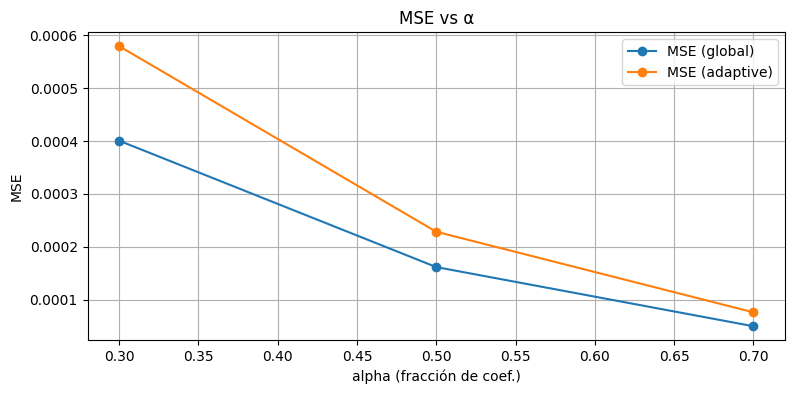

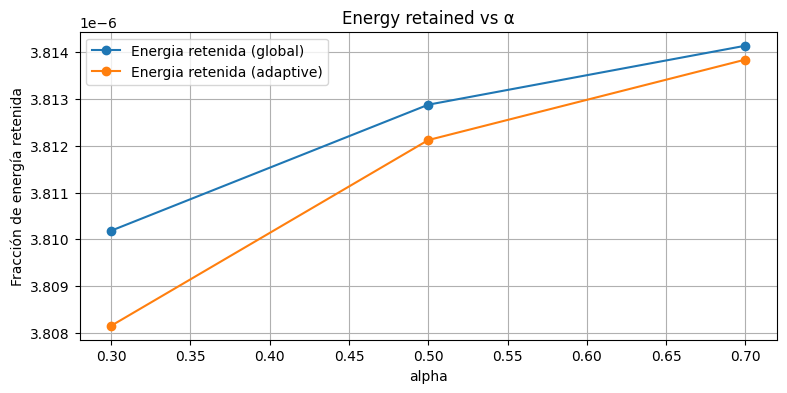

C:\Users\andre\AppData\Local\Temp\ipykernel_30668\1290561009.py:128: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gp = imread(f"../reports/recon_alpha_{int(a*100)}_global.png")
C:\Users\andre\AppData\Local\Temp\ipykernel_30668\1290561009.py:129: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ap = imread(f"../reports/recon_alpha_{int(a*100)}_adaptive.png")


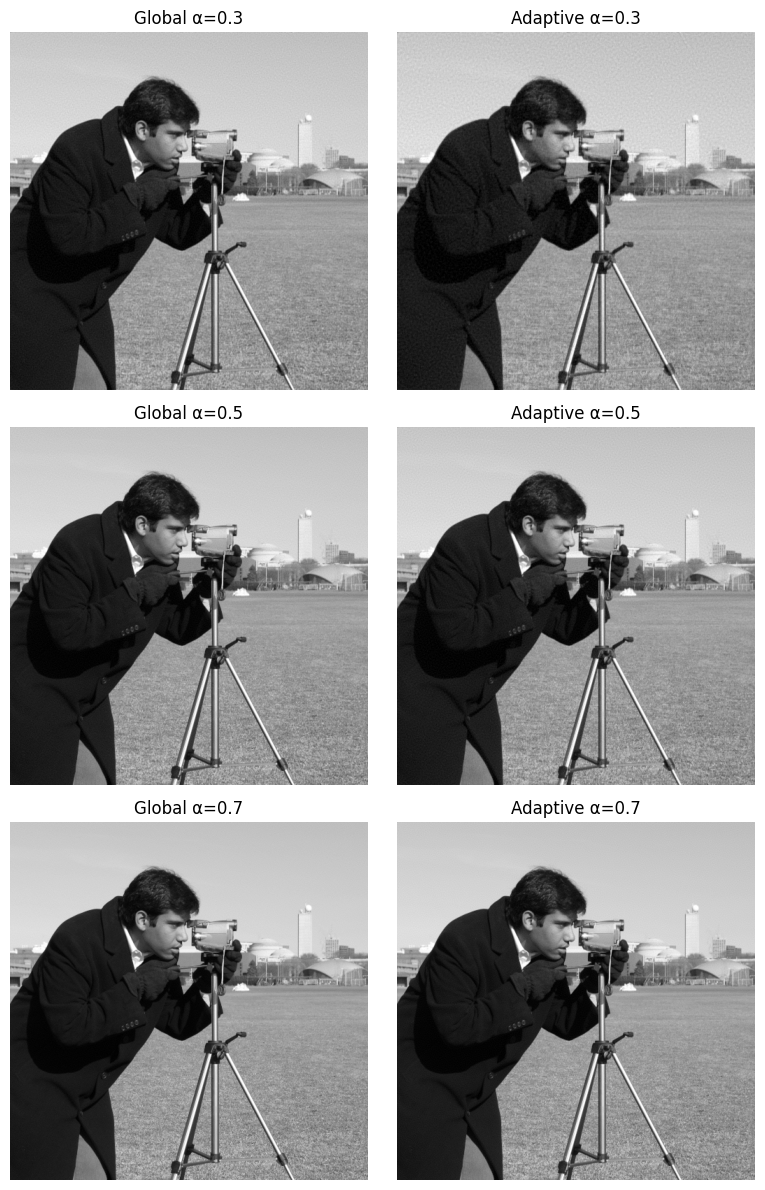

Resultados guardados en ../reports/ y notas en ../diary/


In [2]:
# ------------------ CELDA CORREGIDA: utilidades y experimento ------------------

# (Asume imports y definiciones previas: numpy, plt, ifft2, ifftshift, etc.)

# (global_prune y adaptive_radial_prune ya definidos arriba; si quieres usa la versión corregida que te pasé)

def reconstruct_from_mask(F, mask):
    """Reconstruye imagen real a partir de F * mask (asumiendo F centrado)."""
    # asegurarnos boolean mask
    mask = np.asarray(mask, dtype=bool)
    Fc = np.zeros_like(F, dtype=F.dtype)
    Fc[mask] = F[mask]
    img_rec = np.real(ifft2(ifftshift(Fc)))
    return img_rec

def energy_retained(F, mask):
    E_total = energy_from_spectrum(F)
    # use mask boolean
    mask = np.asarray(mask, dtype=bool)
    E_kept = np.sum(np.abs(F[mask])**2)/(M*N)
    return E_kept, E_kept / E_total

def estimate_compressed_bytes(k, store_indices_bytes=8):
    per_coeff = 16 + store_indices_bytes
    return int(k * per_coeff)

# run_experiments con guardas y logs
def run_experiments(F, img, alphas=[0.3,0.5,0.7], adaptive_bins=8):
    results = []
    original_bytes = img.nbytes  # aproximación (array float64)
    for alpha in alphas:
        print(f"\n>>> Alpha = {alpha}  (bins={adaptive_bins})")
        # GLOBAL PRUNE
        mask_g, k_g = global_prune(F, alpha)
        img_g = reconstruct_from_mask(F, mask_g)
        # clip antes de métricas/guardado
        img_g_clipped = np.clip(img_g, 0.0, 1.0).astype(np.float32)
        mse_g, psnr_g, ssim_g = evaluate(img, img_g_clipped)
        E_kept_g, frac_E_g = energy_retained(F, mask_g)
        bytes_g = estimate_compressed_bytes(k_g)
        ratio_g = original_bytes / bytes_g if bytes_g>0 else np.inf
        print(f" Global: k_target={int(round(alpha*M*N))}, k_selected={int(k_g)}, E_frac={frac_E_g:.6f}")

        # ADAPTIVE PRUNE
        mask_a, k_a, alloc = adaptive_radial_prune(F, alpha, num_bins=adaptive_bins)
        img_a = reconstruct_from_mask(F, mask_a)
        img_a_clipped = np.clip(img_a, 0.0, 1.0).astype(np.float32)
        mse_a, psnr_a, ssim_a = evaluate(img, img_a_clipped)
        E_kept_a, frac_E_a = energy_retained(F, mask_a)
        bytes_a = estimate_compressed_bytes(k_a)
        ratio_a = original_bytes / bytes_a if bytes_a>0 else np.inf
        print(f" Adaptive: k_target={int(round(alpha*M*N))}, k_selected={int(k_a)}, E_frac={frac_E_a:.6f}, alloc_sample={dict(list(alloc.items())[:5])}")

        results.append({
            "alpha": alpha,
            "method": "global",
            "k": int(k_g),
            "mse": float(mse_g),
            "psnr": float(psnr_g),
            "ssim": float(ssim_g),
            "energy_kept": float(E_kept_g),
            "energy_frac": float(frac_E_g),
            "bytes_est": int(bytes_g),
            "comp_ratio": float(ratio_g),
            "alloc": None
        })
        results.append({
            "alpha": alpha,
            "method": "adaptive",
            "k": int(k_a),
            "mse": float(mse_a),
            "psnr": float(psnr_a),
            "ssim": float(ssim_a),
            "energy_kept": float(E_kept_a),
            "energy_frac": float(frac_E_a),
            "bytes_est": int(bytes_a),
            "comp_ratio": float(ratio_a),
            "alloc": alloc
        })

        # guardar imágenes de ejemplo (clipped)
        out_g_path = f"../reports/recon_alpha_{int(alpha*100)}_global.png"
        out_a_path = f"../reports/recon_alpha_{int(alpha*100)}_adaptive.png"
        plt.imsave(out_g_path, img_g_clipped, cmap="gray", vmin=0, vmax=1)
        plt.imsave(out_a_path, img_a_clipped, cmap="gray", vmin=0, vmax=1)

    df = pd.DataFrame(results)
    # guardar CSV
    df.to_csv("../reports/compression_alpha_results.csv", index=False)
    print("\nCSV guardado en ../reports/compression_alpha_results.csv")
    return df

# Ejecutar
alphas = [0.3, 0.5, 0.7]
df_results = run_experiments(F, img, alphas=alphas, adaptive_bins=12)
print(df_results)

# Graficar resumen (igual que antes)
plt.figure(figsize=(9,4))
for method in ["global", "adaptive"]:
    sub = df_results[df_results.method==method]
    plt.plot(sub.alpha, sub.mse, marker='o', label=f"MSE ({method})")
plt.xlabel("alpha (fracción de coef.)")
plt.ylabel("MSE")
plt.legend()
plt.title("MSE vs α")
plt.grid(True)
plt.savefig("../reports/mse_vs_alpha.png")
plt.show()

plt.figure(figsize=(9,4))
for method in ["global", "adaptive"]:
    sub = df_results[df_results.method==method]
    plt.plot(sub.alpha, sub.energy_frac, marker='o', label=f"Energia retenida ({method})")
plt.xlabel("alpha")
plt.ylabel("Fracción de energía retenida")
plt.legend()
plt.title("Energy retained vs α")
plt.grid(True)
plt.savefig("../reports/energy_vs_alpha.png")
plt.show()

# Visual grid (seguro)
from imageio import imread
imgs_plot = []
titles = []
for a in alphas:
    gp = imread(f"../reports/recon_alpha_{int(a*100)}_global.png")
    ap = imread(f"../reports/recon_alpha_{int(a*100)}_adaptive.png")
    imgs_plot.append(gp)
    titles.append(f"Global α={a}")
    imgs_plot.append(ap)
    titles.append(f"Adaptive α={a}")

n = len(imgs_plot)
cols = 2
rows = n//cols
fig, ax = plt.subplots(rows, cols, figsize=(8, 4*rows))
for i, im in enumerate(imgs_plot):
    r = i // cols
    c = i % cols
    ax[r, c].imshow(im, cmap="gray", vmin=0, vmax=255 if im.dtype==np.uint8 else 1)
    ax[r, c].set_title(titles[i])
    ax[r, c].axis("off")
plt.tight_layout()
plt.savefig("../reports/compression_visual_grid.png")
plt.show()

# Guardar bitácora con fallback seguro si falta tabulate
with open("../diary/compression_notes.md", "a", encoding="utf-8") as f:
    f.write("\n---\nExperimento: alpha-pruning global vs adaptativo\n")
    try:
        md = df_results.to_markdown(index=False)
    except Exception:
        md = df_results.to_string(index=False)
    f.write(md + "\nInterpretación: se compara MSE, PSNR, SSIM y energía retenida.\n")

print("Resultados guardados en ../reports/ y notas en ../diary/")



In [3]:
# ----------------------------
# Celda X - Módulo DCT / JPEG-like
# ----------------------------
from scipy.fftpack import dct, idct
import math

# Tabla de cuantización luminancia JPEG (estándar 8x8)
Q_luminance = np.array([
 [16,11,10,16,24,40,51,61],
 [12,12,14,19,26,58,60,55],
 [14,13,16,24,40,57,69,56],
 [14,17,22,29,51,87,80,62],
 [18,22,37,56,68,109,103,77],
 [24,35,55,64,81,104,113,92],
 [49,64,78,87,103,121,120,101],
 [72,92,95,98,112,100,103,99]
], dtype=float)

def scale_quant_table(Q, quality):
    """
    Escala la tabla Q según la calidad (1..100) como en JPEG:
    si quality < 50: scale = 5000 / quality
    else: scale = 200 - 2*quality
    """
    q = np.clip(quality, 1, 100)
    if q < 50:
        scale = 5000.0 / q
    else:
        scale = 200.0 - 2.0*q
    Qs = np.floor((Q * scale + 50) / 100)
    Qs[Qs < 1] = 1
    return Qs

def block_view(arr, block=(8,8)):
    """Divide un array 2D en bloques no solapados (vista)."""
    M, N = arr.shape
    bm, bn = block
    # recorte si no divisible
    M2 = (M // bm) * bm
    N2 = (N // bn) * bn
    arrc = arr[:M2, :N2]
    return arrc.reshape(M2//bm, bm, N2//bn, bn).swapaxes(1,2).reshape(-1, bm, bn), (M2, N2)

def unblock_view(blocks, shape, block=(8,8)):
    bm, bn = block
    M2, N2 = shape
    nb_r = M2 // bm
    nb_c = N2 // bn
    arr = np.stack(blocks).reshape(nb_r, nb_c, bm, bn).swapaxes(1,2).reshape(M2, N2)
    return arr

def dct2(block):
    """2D DCT type II (norm='ortho')"""
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    """2D inverse DCT (type III with norm='ortho')"""
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def jpeg_like_compress(img, quality=50, block_size=8, store_indices_bytes=8):
    """
    Comprime imagen en escala de grises tipo JPEG (bloques 8x8) con quality (1-100).
    Devuelve imagen reconstruida, métricas y stats.
    """
    # asegurar float y rango [0,1]
    orig = np.asarray(img, dtype=float)
    orig = np.clip(orig, 0.0, 1.0)
    blocks, shape = block_view(orig, block=(block_size, block_size))
    Qs = scale_quant_table(Q_luminance, quality)
    quantized_blocks = []
    nonzero_count = 0
    total_coeffs = 0
    recon_blocks = []

    for b in blocks:
        B = b - 0.5  # centrar (como en JPEG se centra alrededor de 128; aquí rango [0,1] centramos en 0)
        D = dct2(B)
        # cuantizar
        Dq = np.round(D / Qs)
        nonzero = np.count_nonzero(Dq)
        nonzero_count += nonzero
        total_coeffs += Dq.size
        # guardar
        quantized_blocks.append(Dq)
        # reconstruir bloque (decuantizar)
        Ddq = Dq * Qs
        rec = idct2(Ddq) + 0.5
        recon_blocks.append(rec)

    M2, N2 = shape
    img_rec = unblock_view(recon_blocks, (M2, N2), block=(block_size, block_size))
    # si la imagen original tenía tamaño no múltiplo de 8, pegamos la parte reconstruida sobre la original
    if img_rec.shape != orig.shape:
        out = np.copy(orig)
        out[:img_rec.shape[0], :img_rec.shape[1]] = img_rec
        img_rec = out

    # métricas
    mse = mean_squared_error(orig, img_rec)
    dr = orig.max() - orig.min()
    dr = dr if dr != 0 else 1.0
    psnr = peak_signal_noise_ratio(orig, img_rec, data_range=dr)
    ssim = structural_similarity(orig, img_rec, data_range=dr, channel_axis=None)

    # energía retenida (en el dominio espacial, comparable con otras métricas)
    E_orig = np.sum(orig**2)
    E_rec  = np.sum(img_rec**2)
    energy_frac = E_rec / E_orig if E_orig!=0 else 0.0

    bytes_est = int(nonzero_count * (16 + store_indices_bytes))  # 16 bytes para valor complejo (aprox) si se usa float64
    comp_ratio = orig.nbytes / bytes_est if bytes_est>0 else np.inf

    stats = {
        "quality": int(quality),
        "k": int(nonzero_count),
        "total_coeffs": int(total_coeffs),
        "mse": float(mse),
        "psnr": float(psnr),
        "ssim": float(ssim),
        "energy_frac": float(energy_frac),
        "bytes_est": int(bytes_est),
        "comp_ratio": float(comp_ratio)
    }
    return img_rec, stats

# ----------------------------
# Celda Y - Ejecutar pruebas JPEG-like y añadir resultados al DataFrame
# ----------------------------

jpeg_qualities = [10, 30, 50, 70, 90]
jpeg_rows = []

for q in jpeg_qualities:
    rec_jpeg, stats = jpeg_like_compress(img, quality=q, block_size=8)
    # guardar imagen reconstruida
    plt.imsave(f"../reports/recon_jpeg_q{q}.png", rec_jpeg, cmap="gray")
    # imprimir resumen
    print(f"JPEG-like Q={q}: k={stats['k']} coeffs, MSE={stats['mse']:.6f}, PSNR={stats['psnr']:.2f} dB, SSIM={stats['ssim']:.4f}, comp_ratio~{stats['comp_ratio']:.1f}")
    # añadir fila similar al formato df_results
    jpeg_rows.append({
        "alpha": None,
        "method": f"jpeg_q{q}",
        "k": stats["k"],
        "mse": stats["mse"],
        "psnr": stats["psnr"],
        "ssim": stats["ssim"],
        "energy_kept": None,
        "energy_frac": stats["energy_frac"],
        "bytes_est": stats["bytes_est"],
        "comp_ratio": stats["comp_ratio"],
        "alloc": None
    })

# añadir las filas JPEG al DataFrame df_results (si existe)
try:
    df_jpeg = pd.DataFrame(jpeg_rows)
    # concatenar con df_results y guardar nuevo CSV
    df_all = pd.concat([df_results, df_jpeg], ignore_index=True, sort=False)
    df_all.to_csv("../reports/compression_alpha_vs_jpeg_results.csv", index=False)
    print("\nSe guardó compression_alpha_vs_jpeg_results.csv en ../reports/")
except Exception as e:
    print("No existe df_results en memoria. Guarda jpeg rows manualmente. Error:", e)
from scipy.fftpack import dct, idct
import numpy as np

Q_luminance = np.array([
 [16,11,10,16,24,40,51,61],
 [12,12,14,19,26,58,60,55],
 [14,13,16,24,40,57,69,56],
 [14,17,22,29,51,87,80,62],
 [18,22,37,56,68,109,103,77],
 [24,35,55,64,81,104,113,92],
 [49,64,78,87,103,121,120,101],
 [72,92,95,98,112,100,103,99]
], dtype=float)

def scale_quant_table(Q, quality):
    q = np.clip(quality, 1, 100)
    if q < 50:
        scale = 5000.0 / q
    else:
        scale = 200.0 - 2.0*q
    Qs = np.floor((Q * scale + 50) / 100)
    Qs[Qs < 1] = 1
    return Qs

def block_view(arr, block=(8,8)):
    M, N = arr.shape
    bm, bn = block
    M2 = (M // bm) * bm
    N2 = (N // bn) * bn
    arrc = arr[:M2, :N2]
    # blocks stacked shape: (num_blocks, bm, bn)
    blocks = arrc.reshape(M2//bm, bm, N2//bn, bn).swapaxes(1,2).reshape(-1, bm, bn)
    return blocks, (M2, N2)

def unblock_view(blocks, shape, block=(8,8)):
    bm, bn = block
    M2, N2 = shape
    nb_r = M2 // bm
    nb_c = N2 // bn
    arr = np.stack(blocks).reshape(nb_r, nb_c, bm, bn).swapaxes(1,2).reshape(M2, N2)
    return arr

def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def jpeg_like_compress(img, quality=50, block_size=8, store_indices_bytes=8):
    # img: numpy array in [0,1]
    orig = np.clip(np.asarray(img, dtype=float), 0.0, 1.0)
    orig_255 = (orig * 255.0).astype(np.float32)
    blocks, shape = block_view(orig_255, block=(block_size, block_size))
    Qs = scale_quant_table(Q_luminance, quality)
    quantized_blocks = []
    recon_blocks = []
    nonzero_count = 0
    total_coeffs = 0

    for b in blocks:
        B = b - 128.0
        D = dct2(B)
        Dq = np.round(D / Qs)
        nonzero_count += np.count_nonzero(Dq)
        total_coeffs += Dq.size
        Ddq = Dq * Qs
        rec = idct2(Ddq) + 128.0
        rec = np.clip(rec, 0, 255)
        recon_blocks.append(rec)

    img_rec_255 = unblock_view(recon_blocks, shape, block=(block_size, block_size))
    # if original image had extra rows/cols, paste reconstructed part back
    if img_rec_255.shape != orig.shape:
        out = np.copy(orig_255)
        M2, N2 = img_rec_255.shape
        out[:M2, :N2] = img_rec_255
        img_rec_255 = out
    img_rec = (img_rec_255 / 255.0).astype(np.float32)

    # metrics
    from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
    mse = mean_squared_error(orig, img_rec)
    dr = orig.max() - orig.min()
    dr = dr if dr != 0 else 1.0
    psnr = peak_signal_noise_ratio(orig, img_rec, data_range=dr)
    ssim = structural_similarity(orig, img_rec, data_range=dr, channel_axis=None)

    # energy_frac in spatial domain
    E_orig = np.sum(orig**2)
    E_rec = np.sum(img_rec**2)
    energy_frac = E_rec / E_orig if E_orig != 0 else 0.0
    bytes_est = int(nonzero_count * (16 + store_indices_bytes))
    comp_ratio = orig.nbytes / bytes_est if bytes_est > 0 else np.inf

    stats = {
        "quality": int(quality),
        "k": int(nonzero_count),
        "total_coeffs": int(total_coeffs),
        "mse": float(mse),
        "psnr": float(psnr),
        "ssim": float(ssim),
        "energy_frac": float(energy_frac),
        "bytes_est": int(bytes_est),
        "comp_ratio": float(comp_ratio)
    }
    return img_rec, stats


JPEG-like Q=10: k=0 coeffs, MSE=0.083445, PSNR=10.79 dB, SSIM=0.4313, comp_ratio~inf


JPEG-like Q=30: k=0 coeffs, MSE=0.083445, PSNR=10.79 dB, SSIM=0.4313, comp_ratio~inf


JPEG-like Q=50: k=0 coeffs, MSE=0.083445, PSNR=10.79 dB, SSIM=0.4313, comp_ratio~inf


JPEG-like Q=70: k=0 coeffs, MSE=0.083445, PSNR=10.79 dB, SSIM=0.4313, comp_ratio~inf


JPEG-like Q=90: k=2704 coeffs, MSE=0.011446, PSNR=19.41 dB, SSIM=0.6102, comp_ratio~32.3

Se guardó compression_alpha_vs_jpeg_results.csv en ../reports/


C:\Users\andre\AppData\Local\Temp\ipykernel_30668\1267908182.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_results, df_jpeg], ignore_index=True, sort=False)
